In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scipy as sp
import seaborn as sns
from sklearn import datasets, linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from sklearn.datasets import load_boston
import itertools

In [2]:
df = pd.read_excel('C:/Users/RicardoEsquivel/Desktop/Estadistica/Estadistica/Ejercicio_2.17.xlsx')
df.head()

,Observ.,X1,X2,X3,X4,Y
0,1,85,10,3,76.5,25.4
1,2,90,9,4,81.0,32.7
2,3,95,13,8,85.5,40.4
3,4,75,20,2,67.5,18.3
4,5,80,14,4,72.0,28.8


In [3]:
#Reportabilidad de estadísticas
df.describe()

,Observ.,X1,X2,X3,X4,Y
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,8.000000,94.000000,11.133333,5.600000,81.500000,38.166667
std,4.472136,20.976177,3.852025,2.354327,19.025359,21.562059
min,1.000000,65.000000,5.000000,2.000000,52.000000,12.500000
25%,4.500000,80.000000,9.000000,4.000000,69.750000,22.250000
50%,8.000000,90.000000,10.000000,5.000000,76.500000,32.700000
75%,11.500000,105.000000,13.500000,7.500000,89.000000,48.900000
max,15.000000,140.000000,20.000000,10.000000,126.000000,80.000000


In [4]:
lr = linear_model.LinearRegression()

In [5]:
X = df[['X1', 'X2', 'X3', 'X4']]
y = df['Y']

In [6]:
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
print('Intercept: \n', lr.intercept_)
print('Coefficients: \n', lr.coef_)

Intercept: 
 -59.522733990405676
Coefficients: 
 [ 1.41334337  0.23368721  0.73098635 -0.51362107]


In [8]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.15, 
                       threshold_out = 0.15, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

Add  X1                             with p-value 4.54178e-10
Add  X4                             with p-value 0.0991583
resulting features:
['X1', 'X4']


In [9]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_out = 0.1, 
                       verbose=True):

    included = list(initial_list)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X, y)

print('resulting features:')
print(result)

resulting features:
[]


In [10]:
all_vars = ['X1', 'X2', 'X3', 'X4']
modelos = []
for k in range(1, len(all_vars)+1):
    subconjuntos = itertools.combinations(all_vars, k)
    for sc in subconjuntos:
        formula = 'y ~ ' + ' + '.join(list(sc))
        resultado = smf.ols(formula, data=df).fit()
        modelos.append({'k': k,
                        'R2adj': resultado.rsquared_adj,
                        'Formula': formula})
df_mdls = pd.DataFrame(modelos)
df_mdls.sort_values(['R2adj'], ascending=False)

,Formula,R2adj,k
6,y ~ X1 + X4,0.957558,2
12,y ~ X1 + X3 + X4,0.956525,3
11,y ~ X1 + X2 + X4,0.955140,3
14,y ~ X1 + X2 + X3 + X4,0.953634,4
0,y ~ X1,0.950394,1
5,y ~ X1 + X3,0.948613,2
4,y ~ X1 + X2,0.946262,2
10,y ~ X1 + X2 + X3,0.943950,3
13,y ~ X2 + X3 + X4,0.854242,3
9,y ~ X3 + X4,0.852648,2


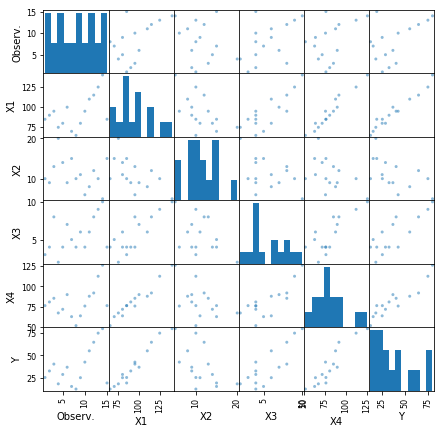

In [11]:
pd.plotting.scatter_matrix(df, figsize=(7, 7));